<a href="https://colab.research.google.com/github/theaveas/DeepLearning/blob/main/NNFS/06_nnfs_introducing_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducing Optimization
The goal of the optimization is to determine how to adjust the weights and biases to decrease the loss.

In [ ]:
import platform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(platform.python_version())
print(np.__version__)
print(matplotlib. __version__)

#python version 3.9.7
#numpy version 1.21.2
#matplotlib version 3.5.0

3.9.7
1.21.2
3.5.0


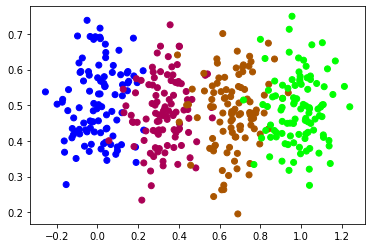

In [ ]:
# create dataset
import nnfs
from nnfs.datasets import vertical_data

nnfs.init()

X, y = vertical_data(samples=100, classes=4)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [ ]:
# import all the previous define class
from nnfs_class import *

In [ ]:
# Create the model
dense1 = Dense(2, 5) # first dense layer, 2 input (x, y coordinate)
activation1 = Activation_ReLU()
dense2 = Dense(5, 4) # second dense layer, 5 inputs, 4 outputs (y is 4 classes)
activation2 = Activation_Softmax()

# compute loss
loss_function = Loss_CategoricalCrossentropy()

In [ ]:
#create some variables to track the best loss and the associated wandb
# Helper variables 
lowest_loss = 9999999 # some initial value 
best_dense1_weights = dense1.weights.copy() 
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy() 
best_dense2_biases = dense2.biases.copy()

In [ ]:
# training neural network

accuracies = []
losses = []
for i in range(100000):
    
    # initialize random wandb
    dense1.weights = 0.02 * np.random.randn(2, 5)
    dense1.biases = 0.02 * np.random.randn(1, 5)
    dense2.weights = 0.02 * np.random.randn(5, 4)
    dense2.biases = 0.02 * np.random.randn(1, 4)
    
    # forward pass
    z1 = dense1.forward(X)
    a1 = activation1.forward(z1)
    z2 = dense2.forward(a1)
    a2 = activation2.forward(z2)
    
    # compute loss
    loss = loss_function.calc(a2, y)
    losses.append(loss)
    
    # calc the accuracy
    predictions = np.argmax(a2, axis=1)
    acc = np.mean(predictions==y)
    accuracies.append(acc)
    
    # Let's start optimize
    if loss < lowest_loss:
        print('New set of weights found, iteration', i, 
              'loss', loss, 'acc', acc)
        best_dense1_weights = dense1.weights.copy() 
        best_dense1_biases = dense1.biases.copy() 
        best_dense2_weights = dense2.weights.copy() 
        best_dense2_biases = dense2.biases.copy()
        # set the newest loss
        lowest_loss = loss

New set of weights found, iteration 0 loss 1.3866973876953126 acc 0.25
New set of weights found, iteration 1 loss 1.3864743041992187 acc 0.25
New set of weights found, iteration 2 loss 1.3864453125 acc 0.25
New set of weights found, iteration 3 loss 1.386409149169922 acc 0.25
New set of weights found, iteration 5 loss 1.3864036560058595 acc 0.25
New set of weights found, iteration 9 loss 1.3862532043457032 acc 0.25
New set of weights found, iteration 17 loss 1.386241455078125 acc 0.25
New set of weights found, iteration 20 loss 1.38620361328125 acc 0.25
New set of weights found, iteration 102 loss 1.3861500549316406 acc 0.25
New set of weights found, iteration 278 loss 1.3861450195312501 acc 0.25
New set of weights found, iteration 341 loss 1.3860787963867187 acc 0.25
New set of weights found, iteration 399 loss 1.3859539794921876 acc 0.25
New set of weights found, iteration 1085 loss 1.385932159423828 acc 0.25
New set of weights found, iteration 4488 loss 1.38585693359375 acc 0.25
New

Loss certainly falls, but not much, acc did not impove

In [ ]:
print('Loss of this model: ', losses[:5], '....', losses[-5:])
print('Accuracy of this model: ', accuracies[:5], "...." , accuracies[-5:])

Loss of this model:  [1.3863430786132813, 1.3862876892089844, 1.3862644958496093, 1.3862664794921875, 1.3863420104980468] .... [1.3862617492675782, 1.38629150390625, 1.3862872314453125, 1.3863616943359376, 1.3862492370605468]
Accuracy of this model:  [0.25, 0.06, 0.25, 0.2525, 0.4175] .... [0.3025, 0.1825, 0.25, 0.1425, 0.25]


In [ ]:
# another method is apply a fraction fo these values to parameters, with this, weights will be updateed from what currently yields us the lowest loss instead of aimlessly randomly.
# training neural network

lowest_loss = 9999999 # some initial value 
accuracies = []
losses = []
for i in range(100000):
    
    # initialize random wandb
    dense1.weights += 0.02 * np.random.randn(2, 5)
    dense1.biases += 0.02 * np.random.randn(1, 5)
    dense2.weights += 0.02 * np.random.randn(5, 4)
    dense2.biases += 0.02 * np.random.randn(1, 4)
    
    # forward pass
    z1 = dense1.forward(X)
    a1 = activation1.forward(z1)
    z2 = dense2.forward(a1)
    a2 = activation2.forward(z2)
    
    # compute loss
    loss = loss_function.calc(a2, y)
    losses.append(loss)
    
    # calc the accuracy
    predictions = np.argmax(a2, axis=1)
    acc = np.mean(predictions==y)
    accuracies.append(acc)
    
    # Let's start optimize
    if loss < lowest_loss: 
        if i > i > 99990:
            print('New set of weights found, iteration', i, 
                  'loss', loss, 'acc', acc)  # show only the last 10
        best_dense1_weights = dense1.weights.copy() 
        best_dense1_biases = dense1.biases.copy() 
        best_dense2_weights = dense2.weights.copy() 
        best_dense2_biases = dense2.biases.copy()
        # set the newest loss
        lowest_loss = loss
        
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()